### Import modules

# Babymoons
#### Code Louisville Data Analysis 2 Project

In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime

## Feature 1: Loading Data
### Read at least two data files
3 csv files are used here

In [ ]:
# Read in and inspect in Variables View

moon_df = pd.read_csv('full-moon-calendar-1900-2050/full_moon.csv')
births1_df = pd.read_csv('fivethirtyeight-births-dataset/US_births_1994-2003_CDC_NCHS.csv')
births2_df = pd.read_csv('fivethirtyeight-births-dataset/US_births_2000-2014_SSA.csv')

## Feature 2: Clean and operate on the data while combining them
### Clean Data
##### Check dataframes for null values

In [ ]:
print(
    'births1_df nulls:\n', births1_df[births1_df.isna().any(axis=1)],
    '\n\nbirths2_df nulls:\n', births2_df[births2_df.isna().any(axis=1)],
    '\n\nmoon_df nulls:\n', moon_df[moon_df.isna().any(axis=1)]
)

No null values found

##### Check data types and eliminate any extra whitespace

In [ ]:
# Check data types

print(
    'births1_df dtypes:\n', births1_df.dtypes, 
    '\n\nbirths2_df dtypes:\n', births2_df.dtypes,
    '\n\nmoon_df dtypes:\n', moon_df.dtypes
)

In [ ]:
# It looks there's some extra whitespace in the column names, let's check it out

print(
    'births1_df:\n', births1_df.columns,
    '\n\nbirths2_df:\n', births2_df.columns,
    '\n\nmoon_df:\n', moon_df.columns
)

In [ ]:
# There's definitely leading whitespace in front of the moon_df column names - perform strip and view results

moon_df.columns = moon_df.columns.str.lstrip()

moon_df.columns

In [ ]:
# Remove any leading and trailing whitespace that might be present from the Day column in moon_df

moon_df['Day'].str.strip()

Everything looks as expected

##### Correct dates to YYYY-MM-DD format in all 3 datasets

In [ ]:
# Start with moon_df, printing dtypes again to confirm successfully converted to datetime

moon_df['Date'] = pd.to_datetime(moon_df['Date'])

print(moon_df.dtypes, moon_df.head(), sep='\n\n')

In [ ]:
# Next do the birth datasets and check results

births1_df['Date'] = pd.to_datetime(births1_df.year.astype(str) + '-' + births1_df.month.astype(str) + '-' + births1_df.date_of_month.astype(str))

print(births1_df.head(3), births1_df.dtypes, sep='\n\n')

In [ ]:
births2_df['Date'] = pd.to_datetime(births2_df.year.astype(str) + '-' + births2_df.month.astype(str) + '-' + births2_df.date_of_month.astype(str))

print(births2_df.head(3), births2_df.dtypes, sep='\n\n')

##### Combine birth datasets

In [ ]:
# Combine birth data into one dataframe

births_df = pd.concat([births1_df, births2_df], ignore_index=True)

Looks good in Variables View

##### Drop duplicate dates since the datasets overlap from 2000-2003

In [ ]:
# Check the starting number of rows

births_df.shape

In [ ]:
# Drop rows that match on date and verify that rows have been dropped

births_df.drop_duplicates(subset=['Date'], keep='last', inplace=True)

births_df.shape

### Replace day of week numbers with names in birth dataset

- We may want to look at births on different days of the week as part of our analysis

In [ ]:
# According to kaggle documentation, 1 is Monday and 7 is Sunday

day_names_dict = {
                    1: 'Monday',
                    2: 'Tuesday',
                    3: 'Wednesday',
                    4: 'Thursday',
                    5: 'Friday',
                    6: 'Saturday',
                    7: 'Sunday'
                    }

In [ ]:
# Create series of day numbers from births_df

day_numbers = births_df['day_of_week']

In [ ]:
# Create day names series using series.map()

day_names = day_numbers.map(day_names_dict)

In [ ]:
# Adding day names series to births_df using same column name as moon_df

births_df['Day'] = day_names

## Create final dataset
### Perform a pandas merge

In [ ]:
# Use Date columns to merge and keep everything in births_df, with only matching rows from moon_df

babymoons_df = pd.merge(births_df, moon_df, how = 'left', on = ['Date', 'Day'])

In [ ]:
# Confirm that the number of rows equals that of births_df

babymoons_df.shape

Everything looks good in Variables View

### Drop unnecessary columns

In [ ]:
babymoons_df.drop(['year', 'month', 'date_of_month', 'day_of_week'], axis=1, inplace=True)
babymoons_df.head()

### Indicate where full moons occur

- The Time column has been retained from moons_df, so any entry there that is not NaN represents a full moon
- We won't be using the times of the full moon, so we'll change the column to say "yes" or "no" for whether there was a full moon

In [ ]:
# Fill in 'No' wherever NaN is present in Time column and confirm result

babymoons_df['Time'].fillna('No', inplace=True)

In [ ]:
# Next, replace values in the Time column that don't say 'No' with 'Yes' and confirm result

babymoons_df.loc[babymoons_df['Time'] != 'No','Time']='Yes'

In [ ]:
# Rename Time column (and capitalize births column for consistency)

babymoons_df.rename(columns= {'births':'Births', 'Time':'Full Moon'}, inplace=True)
babymoons_df.columns

## Answering questions with the new dataset

We want to know if more babies are born on the full moon on average

In [ ]:
# Start looking at descriptive statistics and group by presence or absence of full moon

babymoons_df.groupby('Full Moon').agg({'Births': ['mean', 'median', 'min', 'max']}).round(1)

# Feature 3: Visualize / Present Your Data

## Make 3 matplotlib/seaborn visualizations to display your data

In [ ]:
# It doesn't look like there's a big difference between full moon days and other days, 
# but small differences can be significant - let's look at distributions with boxplots and histograms

sns.boxplot(babymoons_df, x='Births', y='Full Moon')

There is a slightly wider range of births on non-full moon days, but they do not look very different.

In [ ]:
# Look at overall distribution of births

sns.histplot(babymoons_df, x='Births').set(title="All Births")

In [ ]:
sns.histplot(babymoons_df[babymoons_df["Full Moon"]=="Yes"], x='Births').set(title="Full Moon Births")

In [ ]:
sns.histplot(babymoons_df[babymoons_df["Full Moon"]=="No"], x='Births').set(title="Non Full Moon Births")

The distributions all are roughly the same shape (bimodal). But since the distributions are bimodal, that means that our mean calculations are not accurately describing the center of the data, since there are really two centers.

According to https://www.statology.org/bimodal-distribution/, bimodal distributions are usually caused by an underlying phenomena or two different groups being lumped together without realizing it. To investigate what might be going on here, let's try looking at other aspects of the data to see if there are really two groups here.

In [ ]:
# Let's check out days of the week

sns.histplot(babymoons_df, x='Births', hue='Day').set(title="Births by Day of Week")

Interesting! It looks like Saturdays and Sundays have a lot more births in the lower peak (and possibly another day or two that we can't tell because of the overlap). Let's investigate further.

In [ ]:
# Let's compare boxplots across the days of the week - maybe there will be less spread

sns.boxplot(babymoons_df, x='Births', y='Day').set(title='Births by Day of Week')

There could be a real difference between weekdays and weekends, so let's add a column for that to our dataframe

In [82]:
# Assign the weekend days to new column one at a time, then fill the rest with weekday designation.

babymoons_df.loc[babymoons_df['Day']=='Sunday', 'Part of Week'] = 'Weekend'
babymoons_df.loc[babymoons_df['Day']=='Saturday', 'Part of Week'] = 'Weekend'
babymoons_df['Part of Week'].fillna('Weekday', inplace=True)

<AxesSubplot:xlabel='Births', ylabel='Count'>

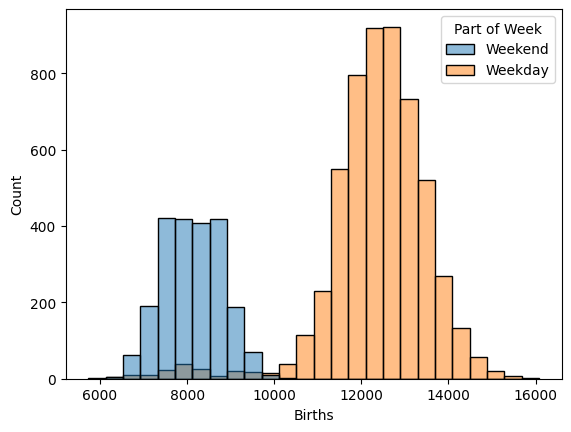

In [85]:
# Let's take a look at the distributions

sns.histplot(babymoons_df, x='Births', hue='Part of Week')

<AxesSubplot:xlabel='Births', ylabel='Part of Week'>

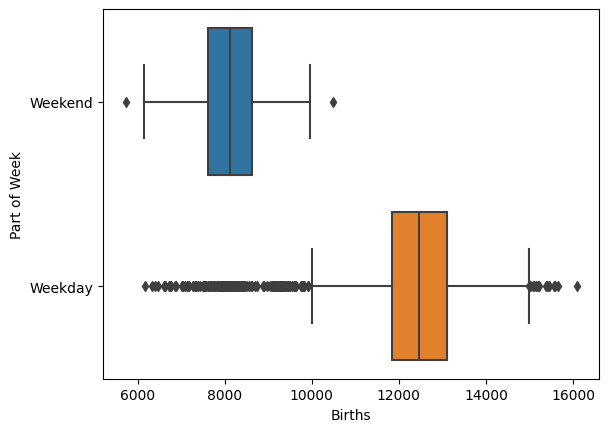

In [86]:
sns.boxplot(babymoons_df, x='Births', y='Part of Week')

Wow! It looks like this explains our bimodal distributions. Let's see if that changes the way our moon data looks.

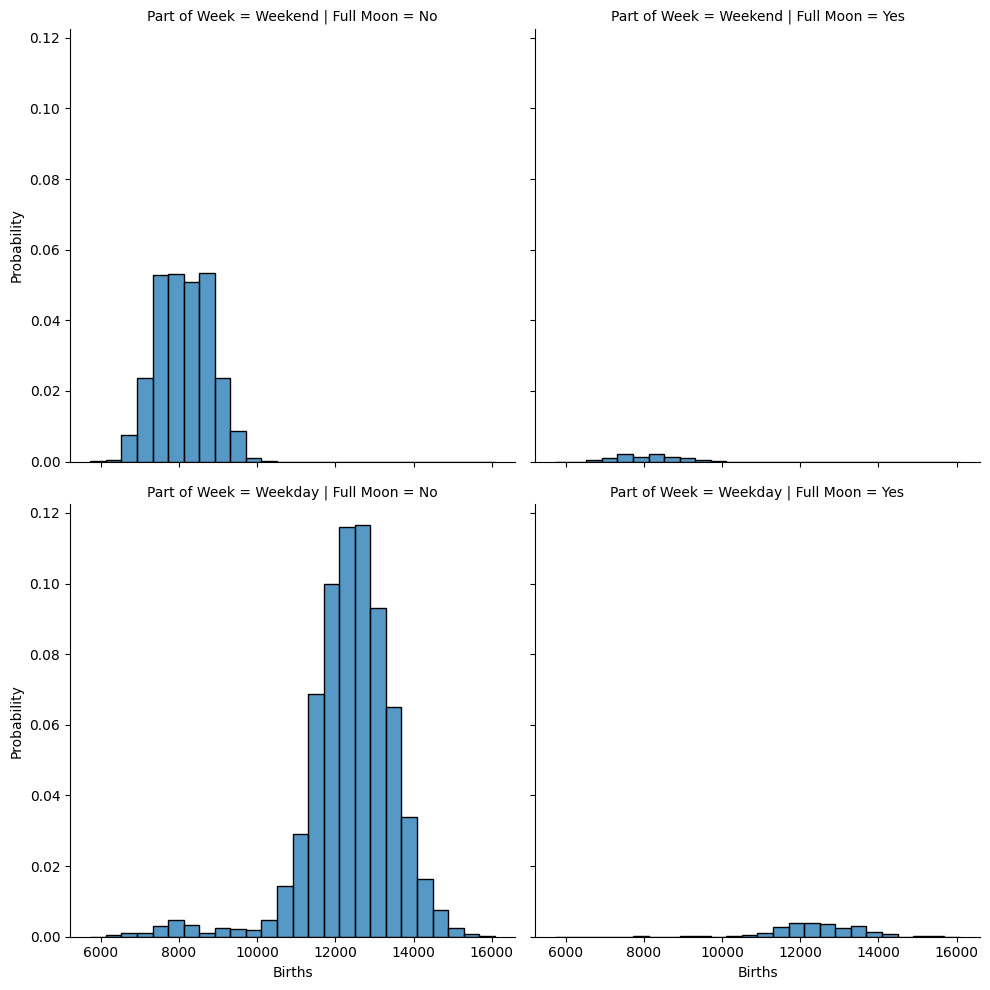

In [88]:
sns.displot(babymoons_df, x='Births', row='Part of Week', col='Full Moon', stat='probability')